In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0,1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0,1


In [2]:
import sys 
sys.path.append("/home/jovyan/work/notebooks/satellite_data/SA_segmentation/")
import sys 
sys.path.append("/home/jovyan/work/notebooks/satellite_data/SA_segmentation/segmentation_models.pytorch")
import segmentation_models_pytorch as smp
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from patchify import patchify
import time
import torch
from torch.functional import F
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
import fiona
from shapely.geometry import shape
import geopandas as gpd
import cv2
from pytorch_segmentation.inference import mosaic_to_raster
from pytorch_segmentation.data.inference_dataset import SatInferenceDataset
from pytorch_segmentation.utils.helper import split_raster_to_grid
#from pytorch_segmentation.utils.preprocessing import unpatchify,pad_image_topleft


seed = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

patch_size = [256,256] # [x,y,bands]
overlap = 128
padding = 64

bval = (255,255,255)
nworkers = 4
bs = 512

year = 2019
dataset_path = "../data/datasets/inference_data"
# data_path = "/home/jovyan/work/satellite_data/ku_sync/South_Africa/merged_v1/23/2327AC_2015.tif"
# shape_path = None
data_path =f"/home/jovyan/work/satellite_data/tmp/{str(year)}.vrt"
shape_path = "/home/jovyan/work/satellite_data/ku_sync/South_Africa/cutlines/SA_all.geojson"
#shape_path = "/home/jovyan/work/notebooks/satellite_data/utils/shapes/2015.shp"#"/home/jovyan/work/satellite_data/tmp/shapes/25/2018.shp"

model_name = "smp_unet_mitb3_08_03_2023_170715" #"unet_24_05_2022_141620"
model_path = "../saved_models/" + model_name +  ".pth" #unet_15_03_2022_071331.pth" #unet_24_03_2022_064749.pth
out_path = "../data/out/"+model_name
#out_path = "/home/jovyan/work/satellite_data/tmp/inference/"+model_name + ".pth/2018"

data_parallel = False
smp_model = True

if smp_model:
    model_class = "smp"
else:
    model_class = "unet"

In [13]:
# data_path = "/home/jovyan/work/notebooks/satellite_data/data/rwanda/images/test/test_rwanda.vrt"

# shape_path = "/home/jovyan/work/notebooks/satellite_data/data/rwanda/Training_rectangles/rectangles_model_29.shp"

# 1. Data Loading and Preprocessing

In [4]:
time_str = time.strftime("%d_%m_%Y_%H%M%S")
s_path = os.path.join(out_path,"tmp_shape_"+time_str+"_"+str(year)+".geojson")
gdf = gpd.read_file(shape_path)
gdf = gdf[gdf["year"] == str(year)]#.reset_index(drop=True)
gdf.to_file(s_path)

In [5]:
shape_idxs = (np.array([ 8])-1).tolist()

In [6]:
# from shapely.geometry import box

# shape_idxs = []
# with rasterio.open(data_path)  as src:
#     extent = box(*src.bounds)
    
#     for i in remaining_idxs:
#         geom = gdf.iloc[i-1]["geometry"]
#         if extent.contains(geom):
#             shape_idxs.append(i-1)
# shape_idxs = shape_idxs#[::-1]

In [7]:
#shape_idxs =list(range(328,340)) + list(range(64,101))  + list(range(133,201))
dataset_path = dataset_path+"_"+time_str+".pkl"

dataset = SatInferenceDataset(data_file_path=data_path,shape_file=s_path,overlap=128,padding=64,shape_idx=shape_idxs)
#dataset = SatInferenceDataset(data_file_path=data_path,shape_file=s_path,overlap=64,padding=32,rescale_factor=2,shape_idx=shape_idxs)

shapes = dataset.shapes.copy()
dataset.save(dataset_path)
 
#del dataset
print(len(dataset))

100%|██████████| 1/1 [00:02<00:00,  2.02s/it]

678150


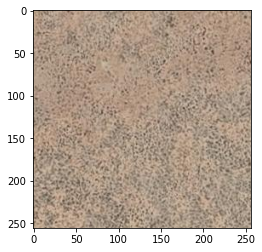

In [8]:
dataset.get_img(500_000)

In [9]:
#Rescaling

# dataset = SatInferenceDataset(data_file_path=data_path,shape_file=shape_path,overlap=64,padding=32,rescale_factor=2,shape_idx=list(range(1,2)))
# shapes = dataset.shapes.copy()
# dataset.save(dataset_path)
 
# #del dataset


# 2. UNet 


# 2.2 Unet

In [10]:
state_dict = torch.load(model_path,map_location="cpu")

if data_parallel:
    # create new OrderedDict that does not contain `module.`
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
else:
    new_state_dict = state_dict


In [11]:
# Change here to adapt to your data
# n_channels=3 for RGB images 
# n_classes is the number of probabilities you want to get per pixel
if smp_model:
    net = smp.Unet(
        encoder_name="mit_b3",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1,                      # model output channels (number of classes in your dataset)
    )
else:
    net = UNet(n_channels=3, n_classes=2, bilinear=False)
    #net= DataParallel(net)

if data_parallel:
    net.load_state_dict(new_state_dict)
else:
    net.load_state_dict(state_dict)
#net.load_state_dict(torch.load(model_path,map_location="cpu"))


#net= DataParallel(net,device_ids=[0,1])
net = net.to(device=device)

# Multi Process Queue In-Memory

In [12]:
from pytorch_segmentation.inference import mosaic_to_raster_mp_queue_memory
mosaic_to_raster(dataset_path,shapes,net,out_path,device_ids=[0,1],
                          bs=bs,pin_memory=True,num_workers=10,model_class=model_class)

Total number of shapes:  1
Shape:  0
24869
Start GPU: 0
24921
Queue PID:  24511


  0%|          | 0/678150 [00:00<?, ?it/s]

Start GPU: 1


  1%|▏         | 10158/678150 [00:39<13:10, 845.08it/s] 

In-Queue length:  0
Out-Queue length:  240
Memory allocated (MB):  2734.24609375


  3%|▎         | 20076/678150 [01:01<16:39, 658.39it/s]  

In-Queue length:  0
Out-Queue length:  480
Memory allocated (MB):  2735.203125


  4%|▍         | 30080/678150 [01:26<11:13, 962.10it/s]  

In-Queue length:  0
Out-Queue length:  208
Memory allocated (MB):  2735.44921875


  6%|▌         | 40108/678150 [01:49<16:41, 637.00it/s]  

In-Queue length:  0
Out-Queue length:  448
Memory allocated (MB):  2735.44921875


  7%|▋         | 50018/678150 [02:13<07:47, 1344.97it/s] 

In-Queue length:  0
Out-Queue length:  176
Memory allocated (MB):  2743.44140625


  9%|▉         | 60108/678150 [02:36<15:23, 669.05it/s]  

In-Queue length:  0
Out-Queue length:  416
Memory allocated (MB):  2745.25


 10%|█         | 70136/678150 [03:01<09:52, 1025.90it/s] 

In-Queue length:  0
Out-Queue length:  1680
Memory allocated (MB):  2746.29296875


 12%|█▏        | 80116/678150 [03:24<11:19, 879.85it/s]  

In-Queue length:  0
Out-Queue length:  896
Memory allocated (MB):  2748.703125


 13%|█▎        | 90148/678150 [03:47<10:24, 941.45it/s]  

In-Queue length:  0
Out-Queue length:  1648
Memory allocated (MB):  2750.09375


 15%|█▍        | 100180/678150 [04:13<09:05, 1058.84it/s]

In-Queue length:  0
Out-Queue length:  864
Memory allocated (MB):  2751.62109375


 16%|█▋        | 110212/678150 [04:34<07:28, 1265.49it/s] 

In-Queue length:  0
Out-Queue length:  1104
Memory allocated (MB):  2753.30078125


 18%|█▊        | 120124/678150 [05:02<11:37, 800.08it/s]  

In-Queue length:  0
Out-Queue length:  2368
Memory allocated (MB):  2755.40234375


 19%|█▉        | 130019/678150 [05:21<06:26, 1417.44it/s] 

In-Queue length:  0
Out-Queue length:  48
Memory allocated (MB):  2757.43359375


 21%|██        | 140196/678150 [05:50<07:42, 1163.44it/s] 

In-Queue length:  0
Out-Queue length:  3000
Memory allocated (MB):  2757.6796875


 22%|██▏       | 150049/678150 [06:10<07:07, 1235.92it/s] 

In-Queue length:  0
Out-Queue length:  528
Memory allocated (MB):  2759.9140625


 24%|██▎       | 160148/678150 [06:37<07:41, 1121.34it/s] 

In-Queue length:  0
Out-Queue length:  2304
Memory allocated (MB):  2762.37109375


 25%|██▌       | 170166/678150 [07:00<10:14, 826.65it/s]  

In-Queue length:  0
Out-Queue length:  2032
Memory allocated (MB):  2762.37109375


 27%|██▋       | 180141/678150 [07:22<06:26, 1288.14it/s] 

In-Queue length:  0
Out-Queue length:  2784
Memory allocated (MB):  2765.07421875


 28%|██▊       | 190116/678150 [07:48<09:48, 829.51it/s]  

In-Queue length:  0
Out-Queue length:  2000
Memory allocated (MB):  2797.7265625


 30%|██▉       | 200152/678150 [08:08<05:52, 1355.87it/s] 

In-Queue length:  0
Out-Queue length:  1728
Memory allocated (MB):  2801.0


 31%|███       | 210094/678150 [08:37<09:09, 851.61it/s]  

In-Queue length:  0
Out-Queue length:  2992
Memory allocated (MB):  2801.0


 32%|███▏      | 220165/678150 [08:56<06:21, 1200.57it/s] 

In-Queue length:  0
Out-Queue length:  2208
Memory allocated (MB):  2804.59765625


 34%|███▍      | 230068/678150 [09:24<09:06, 820.31it/s]  

In-Queue length:  0
Out-Queue length:  1936
Memory allocated (MB):  2804.59765625


 35%|███▌      | 240144/678150 [09:44<08:27, 862.31it/s]  

In-Queue length:  0
Out-Queue length:  640
Memory allocated (MB):  2808.5546875


 37%|███▋      | 250152/678150 [10:12<07:46, 916.64it/s]  

In-Queue length:  1
Out-Queue length:  1392
Memory allocated (MB):  2808.8125


 38%|███▊      | 260097/678150 [10:34<10:05, 690.95it/s] 

In-Queue length:  0
Out-Queue length:  96
Memory allocated (MB):  2813.1640625


 40%|███▉      | 270144/678150 [10:59<09:27, 718.75it/s]  

In-Queue length:  0
Out-Queue length:  336
Memory allocated (MB):  2813.1640625


 41%|████▏     | 280178/678150 [11:24<07:50, 846.35it/s]  

In-Queue length:  0
Out-Queue length:  576
Memory allocated (MB):  2817.95703125


 43%|████▎     | 290255/678150 [11:47<09:41, 666.80it/s]  

In-Queue length:  0
Out-Queue length:  304
Memory allocated (MB):  2817.95703125


 44%|████▍     | 300016/678150 [12:15<08:17, 760.60it/s] 

In-Queue length:  0
Out-Queue length:  32
Memory allocated (MB):  2823.2265625


 46%|████▌     | 310123/678150 [12:38<09:56, 616.95it/s] 

In-Queue length:  0
Out-Queue length:  272
Memory allocated (MB):  2823.2265625


 47%|████▋     | 320000/678150 [13:06<08:14, 724.20it/s] 

In-Queue length:  0
Out-Queue length:  0
Memory allocated (MB):  2829.01953125


 49%|████▊     | 330165/678150 [13:30<26:59, 214.82it/s] 

In-Queue length:  0
Out-Queue length:  240
Memory allocated (MB):  2829.01953125


 53%|█████▎    | 360099/678150 [14:47<10:35, 500.49it/s] 

In-Queue length:  0
Out-Queue length:  448
Memory allocated (MB):  2835.39453125


 55%|█████▍    | 370005/678150 [15:10<18:46, 273.64it/s] 

In-Queue length:  0
Out-Queue length:  176
Memory allocated (MB):  2835.39453125


 56%|█████▌    | 380131/678150 [15:38<15:36, 318.37it/s] 

In-Queue length:  0
Out-Queue length:  416
Memory allocated (MB):  2842.40625


 58%|█████▊    | 390085/678150 [15:59<19:43, 243.48it/s] 

In-Queue length:  0
Out-Queue length:  144
Memory allocated (MB):  2842.6640625


 59%|█████▉    | 400127/678150 [16:24<17:58, 257.81it/s] 

In-Queue length:  0
Out-Queue length:  384
Memory allocated (MB):  2842.6640625


 60%|██████    | 409947/678150 [16:44<04:49, 926.16it/s] 

In-Queue length:  0
Out-Queue length:  112
Memory allocated (MB):  2850.37890625


 62%|██████▏   | 420147/678150 [17:14<05:06, 840.70it/s] 

In-Queue length:  1
Out-Queue length:  352
Memory allocated (MB):  2850.44140625


 63%|██████▎   | 430192/678150 [17:36<03:53, 1061.65it/s]

In-Queue length:  0
Out-Queue length:  592
Memory allocated (MB):  2850.44140625


 65%|██████▍   | 440122/678150 [18:06<03:44, 1061.36it/s]

In-Queue length:  0
Out-Queue length:  1344
Memory allocated (MB):  2850.44140625


 66%|██████▋   | 450115/678150 [18:29<04:22, 867.68it/s] 

In-Queue length:  0
Out-Queue length:  560
Memory allocated (MB):  2858.92578125


 68%|██████▊   | 460196/678150 [18:59<02:40, 1359.93it/s]

In-Queue length:  0
Out-Queue length:  800
Memory allocated (MB):  2858.92578125


 69%|██████▉   | 469992/678150 [19:22<03:58, 874.34it/s] 

In-Queue length:  0
Out-Queue length:  16
Memory allocated (MB):  2858.92578125


 71%|███████   | 480156/678150 [19:51<03:52, 850.22it/s] 

In-Queue length:  0
Out-Queue length:  256
Memory allocated (MB):  2858.92578125


 72%|███████▏  | 490150/678150 [20:17<03:35, 872.81it/s] 

In-Queue length:  0
Out-Queue length:  1520
Memory allocated (MB):  2868.2578125


 74%|███████▍  | 500174/678150 [20:42<03:58, 747.73it/s] 

In-Queue length:  0
Out-Queue length:  736
Memory allocated (MB):  2868.2578125


 75%|███████▌  | 510234/678150 [21:11<02:37, 1064.99it/s]

In-Queue length:  0
Out-Queue length:  464
Memory allocated (MB):  2868.2578125


 77%|███████▋  | 520079/678150 [21:34<03:04, 858.24it/s] 

In-Queue length:  0
Out-Queue length:  192
Memory allocated (MB):  2868.2578125


 78%|███████▊  | 530164/678150 [22:01<05:54, 417.15it/s] 

In-Queue length:  0
Out-Queue length:  432
Memory allocated (MB):  2868.2578125


 80%|███████▉  | 540135/678150 [22:24<01:56, 1182.84it/s]

In-Queue length:  0
Out-Queue length:  160
Memory allocated (MB):  2868.2578125


 81%|████████  | 550197/678150 [22:51<10:25, 204.69it/s] 

In-Queue length:  0
Out-Queue length:  400
Memory allocated (MB):  2878.5234375


 83%|████████▎ | 560092/678150 [23:15<02:27, 797.84it/s] 

In-Queue length:  0
Out-Queue length:  1152
Memory allocated (MB):  2878.5234375


 84%|████████▍ | 570233/678150 [23:41<03:59, 450.69it/s] 

In-Queue length:  0
Out-Queue length:  368
Memory allocated (MB):  2878.5234375


 86%|████████▌ | 580016/678150 [24:05<02:40, 611.78it/s] 

In-Queue length:  0
Out-Queue length:  96
Memory allocated (MB):  2878.5234375


 87%|████████▋ | 590263/678150 [24:32<06:57, 210.60it/s] 

In-Queue length:  0
Out-Queue length:  336
Memory allocated (MB):  2878.5234375


 88%|████████▊ | 599980/678150 [24:52<03:27, 376.23it/s] 

In-Queue length:  0
Out-Queue length:  64
Memory allocated (MB):  2878.5234375


 90%|████████▉ | 610200/678150 [25:22<08:02, 140.78it/s] 

In-Queue length:  0
Out-Queue length:  304
Memory allocated (MB):  2878.5234375


 91%|█████████▏| 619956/678150 [25:37<02:12, 440.67it/s] 

In-Queue length:  0
Out-Queue length:  32
Memory allocated (MB):  2889.81640625


 93%|█████████▎| 630167/678150 [26:05<00:54, 883.77it/s] 

In-Queue length:  0
Out-Queue length:  272
Memory allocated (MB):  2889.81640625


 94%|█████████▍| 639952/678150 [26:27<00:38, 989.60it/s] 

In-Queue length:  0
Out-Queue length:  0
Memory allocated (MB):  2889.81640625


 96%|█████████▌| 650159/678150 [26:58<00:36, 775.17it/s] 

In-Queue length:  0
Out-Queue length:  240
Memory allocated (MB):  2889.81640625


 97%|█████████▋| 660160/678150 [27:19<00:25, 693.37it/s] 

In-Queue length:  0
Out-Queue length:  480
Memory allocated (MB):  2889.81640625


 98%|█████████▊| 666714/678150 [27:36<00:29, 382.65it/s] 

DONE  1


 99%|█████████▉| 670137/678150 [27:45<00:11, 681.11it/s] 

In-Queue length:  0
Out-Queue length:  339
Memory allocated (MB):  2890.07421875


100%|██████████| 678150/678150 [28:16<00:00, 399.62it/s]


DONE  0
INFO: Written ../data/out/smp_unet_mitb3_08_03_2023_170715/tmp_shape_30_03_2023_082011_2019_8.tif in 298.111 seconds


# Backlog

## 2.1. Simple Unet
https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705

In [ ]:
from pytorch_segmentation.models.unet_simple import UNet

net = UNet(patch_size[2],2)
net = net.load_state_dict(torch.load(model_path)).to(device)
net.eval()

In [11]:
output = []
#out = net(X.to(device))
for i,batch in enumerate(dl):
    x = batch.to(device)#[0].to(device)
    out = net(x)
    out = F.softmax(out,dim=1)
    out = torch.argmax(out,dim=1)
    out = out.cpu().numpy().astype("uint8")
    output.append(out)
imgs = np.vstack(output)

In [8]:
out_image = unpatchify(imgs,patches.shape[:2],pad)
out_meta = satellite_img.meta.copy()
out_meta.update({"driver": "GTiff",
                 "count":1,
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": sat_patch_arr_transform})
with rasterio.open(out_file, "w", **out_meta) as dest:
    dest.write(out_image)

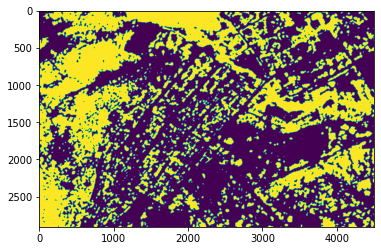

In [9]:
show(out_image);

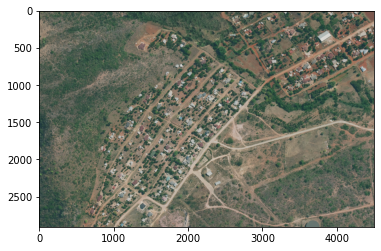

In [10]:
show(sat_patch_arr);

In [16]:
out_image = sat_patch_arr
out_meta = satellite_img.meta.copy()
out_meta.update({"driver": "GTiff",
                 "count":3,
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": sat_patch_arr_transform})
with rasterio.open('data/out/raster.tif', "w", **out_meta) as dest:
    dest.write(out_image)

## Single Process 

In [ ]:
mosaic_to_raster(dataset,net,"data/out/",device_ids=[0,1,2,3,4],bs=650,pin_memory=True,num_workers=20)

# Multi Process

In [ ]:
from pytorch_segmentation.utils.postprocessing import mosaic_to_raster_mp
mosaic_to_raster_mp(dataset_path,net,"data/out/",device_ids=[0,2,3,4],bs=150,pin_memory=True,num_workers=8)

## Multi Process Queue

In [ ]:
from pytorch_segmentation.utils.postprocessing import mosaic_to_raster_mp_queue
mosaic_to_raster_mp_queue(dataset_path,net,"data/out/",mmap_shape=(len_dataset,256,256),device_ids=[0,1,2,3,4],
                          bs=150,pin_memory=True,num_workers=10)